In [33]:
# Quick script to generate the outputs for the literature review
# specifically I need a couple of figures

# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from astLib import astSED
import astropy.io.fits as fits


In [34]:


# Params -
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

swire_folderpath = os.path.join('datasets', 'Templates', 'SWIRE')


# Filters - IRAC
pb_f3_6_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I1.dat')
pb_f4_5_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I2.dat')
pb_f5_8_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I3.dat')
pb_f8_0_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I4.dat')
# In addition also use astSED to create filters
pb_f3_6 = astSED.Passband(pb_f3_6_path, normalise=False)
pb_f4_5 = astSED.Passband(pb_f4_5_path, normalise=False)
pb_f5_8 = astSED.Passband(pb_f5_8_path, normalise=False)
pb_f8_0 = astSED.Passband(pb_f8_0_path, normalise=False)

# Filters -ugr
pb_u_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.u_SDSS.dat')
pb_g_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.g_SDSS.dat')
pb_r_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.r_SDSS.dat')
# In addition also use astSED to create filters
pb_u = astSED.Passband(pb_u_path, normalise=False)
pb_g = astSED.Passband(pb_g_path, normalise=False)
pb_r = astSED.Passband(pb_r_path, normalise=False)





# Filters - UVJ
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')

# In addition also use astSED to create filters
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)



f3_6_arr = np.array(pb_f3_6.asList())
f4_5_arr = np.array(pb_f4_5.asList())
f5_8_arr = np.array(pb_f5_8.asList())
f8_0_arr = np.array(pb_f8_0.asList())


In [35]:

# Create a function to compute the flux integral
def integral_flux(sed):
    return np.trapz(sed['Total Flux (erg/s/cm^2/Angstrom)'], sed['lambda (Angstroms)'])

agn_composite_models = []
for models in range(1, 3):
    if(models == 1):
        # type 1 AGN
        optical_depth = 3 # fixed
        p = 0 # fixed
        q = 0 # fixed
        opening_angle = 50 # fixed
        radius_ratio = 20 # fixed 
        inclination = 0 # you can adjust this between a value of 0 and 90 (in steps of 10 as per the files available)
    elif(models == 2):
        # type 2 AGN
        optical_depth = 3 # fixed
        p = 0
        q = 0
        opening_angle = 50
        radius_ratio = 20
        inclination = 90
        
    # if neither of the above, exit program
    else:
        break
    


    # read in the Skirtor model of the AGN
    filename = 't'+str(optical_depth)+'_p'+str(p)+'_q'+str(q)+'_oa'+str(opening_angle)+'_R'+str(radius_ratio)+'_Mcl0.97_i'+str(inclination)+'_sed.dat'
    # Join the file to the path and then read in the file
    filepath =os.path.join(skirtor_folderpath, filename)
    # Read in the file and convert it to a pandas dataframe
    data = np.loadtxt(filepath, skiprows=5)

    # Convert it to a pandas dataframe # All fluxes are of the form lambda*F_lambda
    df = pd.DataFrame(data)

    # Convert the first column to angstroms
    df[0] = df[0]*10000


    # for the rest of the columns, we need to convert the fluxes to erg/s/cm^2/Angstrom
    df.iloc[:, 1:]

    # Convert W/m2 to erg/s/cm^2/Angstrom
    # first by converting W to erg/s
    df.iloc[:, 1:] = df.iloc[:, 1:]*10**7
        
    # then by converting  ergs/s/m^2 to ergs/s/cm^2
    #df.iloc[:, 1:] = df.iloc[:, 1:]*10**4
        
    # finally by converting ergs/s/cm^2 to ergs/s/cm^2/Angstrom: lambda*f_lambda -> f_lambda
    df.iloc[:, 1:] = df.iloc[:, 1:].div(df[0], axis=0)

    # Name each of the columns appropriately 
    df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)', 'Direct AGN Flux (erg/s/cm^2/Angstrom)', 'Scattered AGN Flux (erg/s/cm^2/Angstrom)', 'Total Dust Emission Flux (erg/s/cm^2/Angstrom)', 'Dust Emission Scattered Flux(erg/s/cm^2/Angstrom)', 'Transparent Flux(erg/s/cm^2/Angstrom)']


    agn_df = df




    df_list = []
    objname_list = []
    swire_folderpath = os.path.join(swire_folderpath)
    files_in_folder = os.listdir(swire_folderpath)


    # make sure to only read .sed files
    file_extension = '.sed'

    # Filter files based on the specified file extension
    files_in_folder = [file for file in files_in_folder if file.endswith(file_extension)]

    for file in files_in_folder:
        # Find filepath and convert to df
        objname = file.split('_template_norm.sed')[0]
        filepath = os.path.join(swire_folderpath, file)
        data = np.loadtxt(filepath)
        df = pd.DataFrame(data)
        
        # Name each of the columns appropriately
        df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
            
        # Append the dataframe to the list    
        df_list.append(df)
        objname_list.append(objname)


    df = agn_df.copy() # set the df to the AGN model
    print(objname_list)
    # n chooses the galaxy we are interested in
    n = 16
    galaxy_df = df_list[n]

    # Given an SED
    wavelengths_sed1 = galaxy_df['lambda (Angstroms)']
    flux_sed1 = galaxy_df['Total Flux (erg/s/cm^2/Angstrom)']

    # Given a model
    wavelengths_sed2 = df['lambda (Angstroms)']
    flux_sed2 = df['Total Flux (erg/s/cm^2/Angstrom)']

    # Get a shared wavelength range across both SEDS
    combined_wavelengths = np.union1d(wavelengths_sed1, wavelengths_sed2)

    # Interpolate flux values for the combined wavelengths
    combined_flux_sed1 = np.interp(combined_wavelengths, wavelengths_sed1, flux_sed1, left=np.nan, right=np.nan)
    combined_flux_sed2 = np.interp(combined_wavelengths, wavelengths_sed2, flux_sed2, left=np.nan, right=np.nan) 

    # We would like to see which sed has the min wavelength , and max wavelength,
    # Cut the AGN and Galaxy model so they are within range of the original swire model
    min_wavelength = np.max([np.min(wavelengths_sed1), np.min(wavelengths_sed2)])
    max_wavelength = np.min([np.max(wavelengths_sed1), np.max(wavelengths_sed2)])

    # Cut the AGN model
    mask = (combined_wavelengths >= min_wavelength) & (combined_wavelengths <= max_wavelength)
    combined_wavelengths = combined_wavelengths[mask]
    combined_flux_sed1 = combined_flux_sed1[mask]
    combined_flux_sed2 = combined_flux_sed2[mask]

    # Create a new dataframe for each SED
    galaxy_df = pd.DataFrame({'lambda (Angstroms)': combined_wavelengths, 'Total Flux (erg/s/cm^2/Angstrom)': combined_flux_sed1}) 
    df = pd.DataFrame({'lambda (Angstroms)': combined_wavelengths, 'Total Flux (erg/s/cm^2/Angstrom)': combined_flux_sed2}) 





    # Calculating the integrated flux for each SED
    integrated_model_flux = integral_flux(df)
    integrated_galaxy_flux = integral_flux(galaxy_df)
    scaling_factor = integrated_galaxy_flux/integrated_model_flux

    # Using this scaling factor, we can now scale the model to the galaxy model
    df['Total Flux (erg/s/cm^2/Angstrom)'] = df['Total Flux (erg/s/cm^2/Angstrom)'] * scaling_factor



    # plt.figure(figsize=(10, 6))
    # plt.loglog(galaxy_df['lambda (Angstroms)'], galaxy_df['Total Flux (erg/s/cm^2/Angstrom)'], label=objname_list[n])
    # plt.loglog(df['lambda (Angstroms)'], df['Total Flux (erg/s/cm^2/Angstrom)'], label='AGN Type 1')
    # plt.xlabel('Wavelength (Angstroms)')
    # plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
    # plt.title('SED of AGN Model')
    # plt.legend()
    # plt.show()

    alpha = np.arange(0, 1.2, 0.2)
    alpha

    # creating a set of composite SEDs
    composite_seds = []
    for a in alpha:
        combined_flux = a * df['Total Flux (erg/s/cm^2/Angstrom)'] + galaxy_df['Total Flux (erg/s/cm^2/Angstrom)']
        
        # use the wavelength of the galaxy SED or AGN sed
        combined_wavelengths = df['lambda (Angstroms)']

        # Create a composite SED DataFrame
        composite_sed_df = pd.DataFrame({'lambda (Angstroms)': combined_wavelengths, 'Total Flux (erg/s/cm^2/Angstrom)': combined_flux})
        
        # add to composite sed list
        composite_seds.append(composite_sed_df)


    # # We can now plot these SEDs and see what an increase of model contribution does to the overal SED
    # plt.figure(figsize=(6, 6))
    # for i, composite_sed in enumerate(composite_seds):
    #     plt.loglog(composite_sed['lambda (Angstroms)'], composite_sed['Total Flux (erg/s/cm^2/Angstrom)'], label=f'Model Contribution: {alpha[i]*100:.0f}%')
    # plt.xlabel('Wavelength (Angstroms)')
    # plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
    # plt.title('Composite SEDs')
    # plt.legend()
    # plt.xlim(1e3, 1e7)
    # plt.ylim(1e-4, 1e2)
    # plt.show()
    
    # Append the composite SEDs to the list
    agn_composite_models.append(composite_seds)

['Arp220', 'BQSO1', 'Ell13', 'Ell2', 'Ell5', 'I19254', 'I20551', 'I22491', 'M82', 'Mrk231', 'N6090', 'N6240', 'QSO1', 'QSO2', 'S0', 'Sa', 'Sb', 'Sc', 'Sdm', 'Sd', 'Sey18', 'Sey2', 'Spi4', 'Torus', 'TQSO1']
['Arp220', 'BQSO1', 'Ell13', 'Ell2', 'Ell5', 'I19254', 'I20551', 'I22491', 'M82', 'Mrk231', 'N6090', 'N6240', 'QSO1', 'QSO2', 'S0', 'Sa', 'Sb', 'Sc', 'Sdm', 'Sd', 'Sey18', 'Sey2', 'Spi4', 'Torus', 'TQSO1']


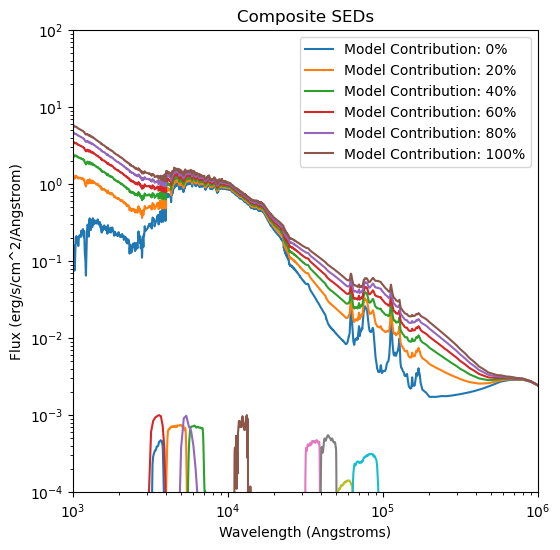

In [41]:
# Create a plot of the composite SEDs with the filters
plt.figure(figsize=(6, 6))
for i, composite_sed in enumerate(agn_composite_models[0]):
    plt.loglog(composite_sed['lambda (Angstroms)'], composite_sed['Total Flux (erg/s/cm^2/Angstrom)'], label=f'Model Contribution: {alpha[i]*100:.0f}%')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Composite SEDs')
plt.legend()
plt.xlim(1e3, 1e7)
plt.ylim(1e-4, 1e2)

sc = 10**-3
# Plot IRAC filters
plt.loglog(pb_f3_6.wavelength, sc*pb_f3_6.transmission)
plt.loglog(pb_f4_5.wavelength, sc*pb_f4_5.transmission)
plt.loglog(pb_f5_8.wavelength, sc*pb_f5_8.transmission)
plt.loglog(pb_f8_0.wavelength, sc*pb_f8_0.transmission)

# plot ugr filters
plt.loglog(pb_u.wavelength, sc*pb_u.transmission)
plt.loglog(pb_g.wavelength, sc*pb_g.transmission)
plt.loglog(pb_r.wavelength, sc*pb_r.transmission)


# Plot UVJ filters
plt.loglog(pb_U.wavelength, sc*pb_U.transmission)
plt.loglog(pb_V.wavelength, sc*pb_V.transmission)
plt.loglog(pb_J.wavelength, sc*pb_J.transmission)

plt.xlim(1e3, 1e6)

plt.show()

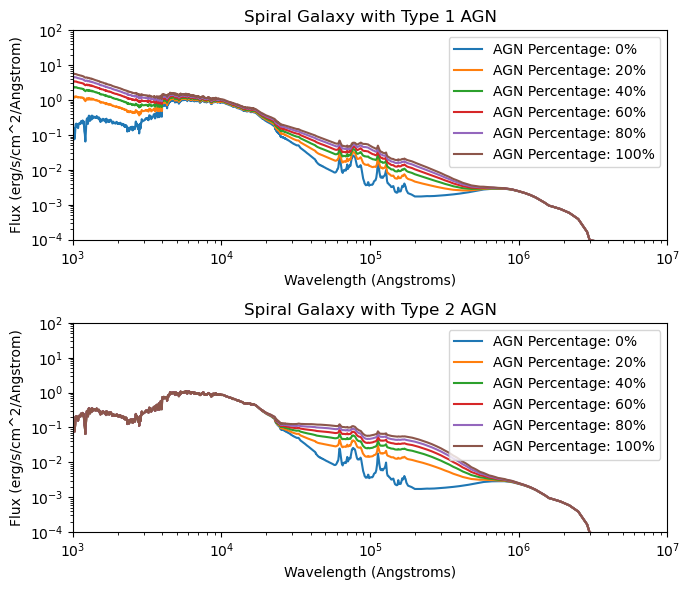

In [37]:
 
# Now we have both models we can plot them side by side 
# Create subplot of the two models
fig, ax = plt.subplots(2, 1, figsize=(7, 6))
for i, composite_sed in enumerate(agn_composite_models[0]):
    ax[0].loglog(composite_sed['lambda (Angstroms)'], composite_sed['Total Flux (erg/s/cm^2/Angstrom)'], label=f'AGN Percentage: {alpha[i]*100:.0f}%')
ax[0].set_xlabel('Wavelength (Angstroms)')
ax[0].set_ylabel('Flux (erg/s/cm^2/Angstrom)')
ax[0].set_title('Spiral Galaxy with Type 1 AGN')
ax[0].legend()
ax[0].set_xlim(1e3, 1e7)
ax[0].set_ylim(1e-4, 1e2)

for i, composite_sed in enumerate(agn_composite_models[1]):
    ax[1].loglog(composite_sed['lambda (Angstroms)'], composite_sed['Total Flux (erg/s/cm^2/Angstrom)'], label=f'AGN Percentage: {alpha[i]*100:.0f}%')
ax[1].set_xlabel('Wavelength (Angstroms)')
ax[1].set_ylabel('Flux (erg/s/cm^2/Angstrom)')
ax[1].set_title('Spiral Galaxy with Type 2 AGN')
# set legend to the side
ax[1].legend()
ax[1].set_xlim(1e3, 1e7)
ax[1].set_ylim(1e-4, 1e2)

# layout
plt.tight_layout()

# Save the output 
plt.savefig('outputs/sed_agn_contaminiation.png', dpi=300, bbox_inches='tight')

plt.show()



# We would also like to produce a blue and a red galaxy - associated with a elliptical and a spiral galaxy
# plot the swire templates
